<a href="https://colab.research.google.com/github/iPrinka/MITx-Micromasters-Statistics-Data-Science/blob/main/oneleague_ml_pytorch_convnet_cifar_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Training a Convolutional Net in `PyTorch`

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import CIFAR10, ImageFolder
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#### Using Other Models

In [ ]:
# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Images
imgs = ['https://nypost.com/wp-content/uploads/sites/2/2022/06/reddit-cats-judging-looks-00.jpg?quality=75&strip=all']  # batch of images

# Inference
results = model(imgs)

/usr/local/lib/python3.9/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: YOLOv5 requirement "gitpython>=3.1.30" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 11.

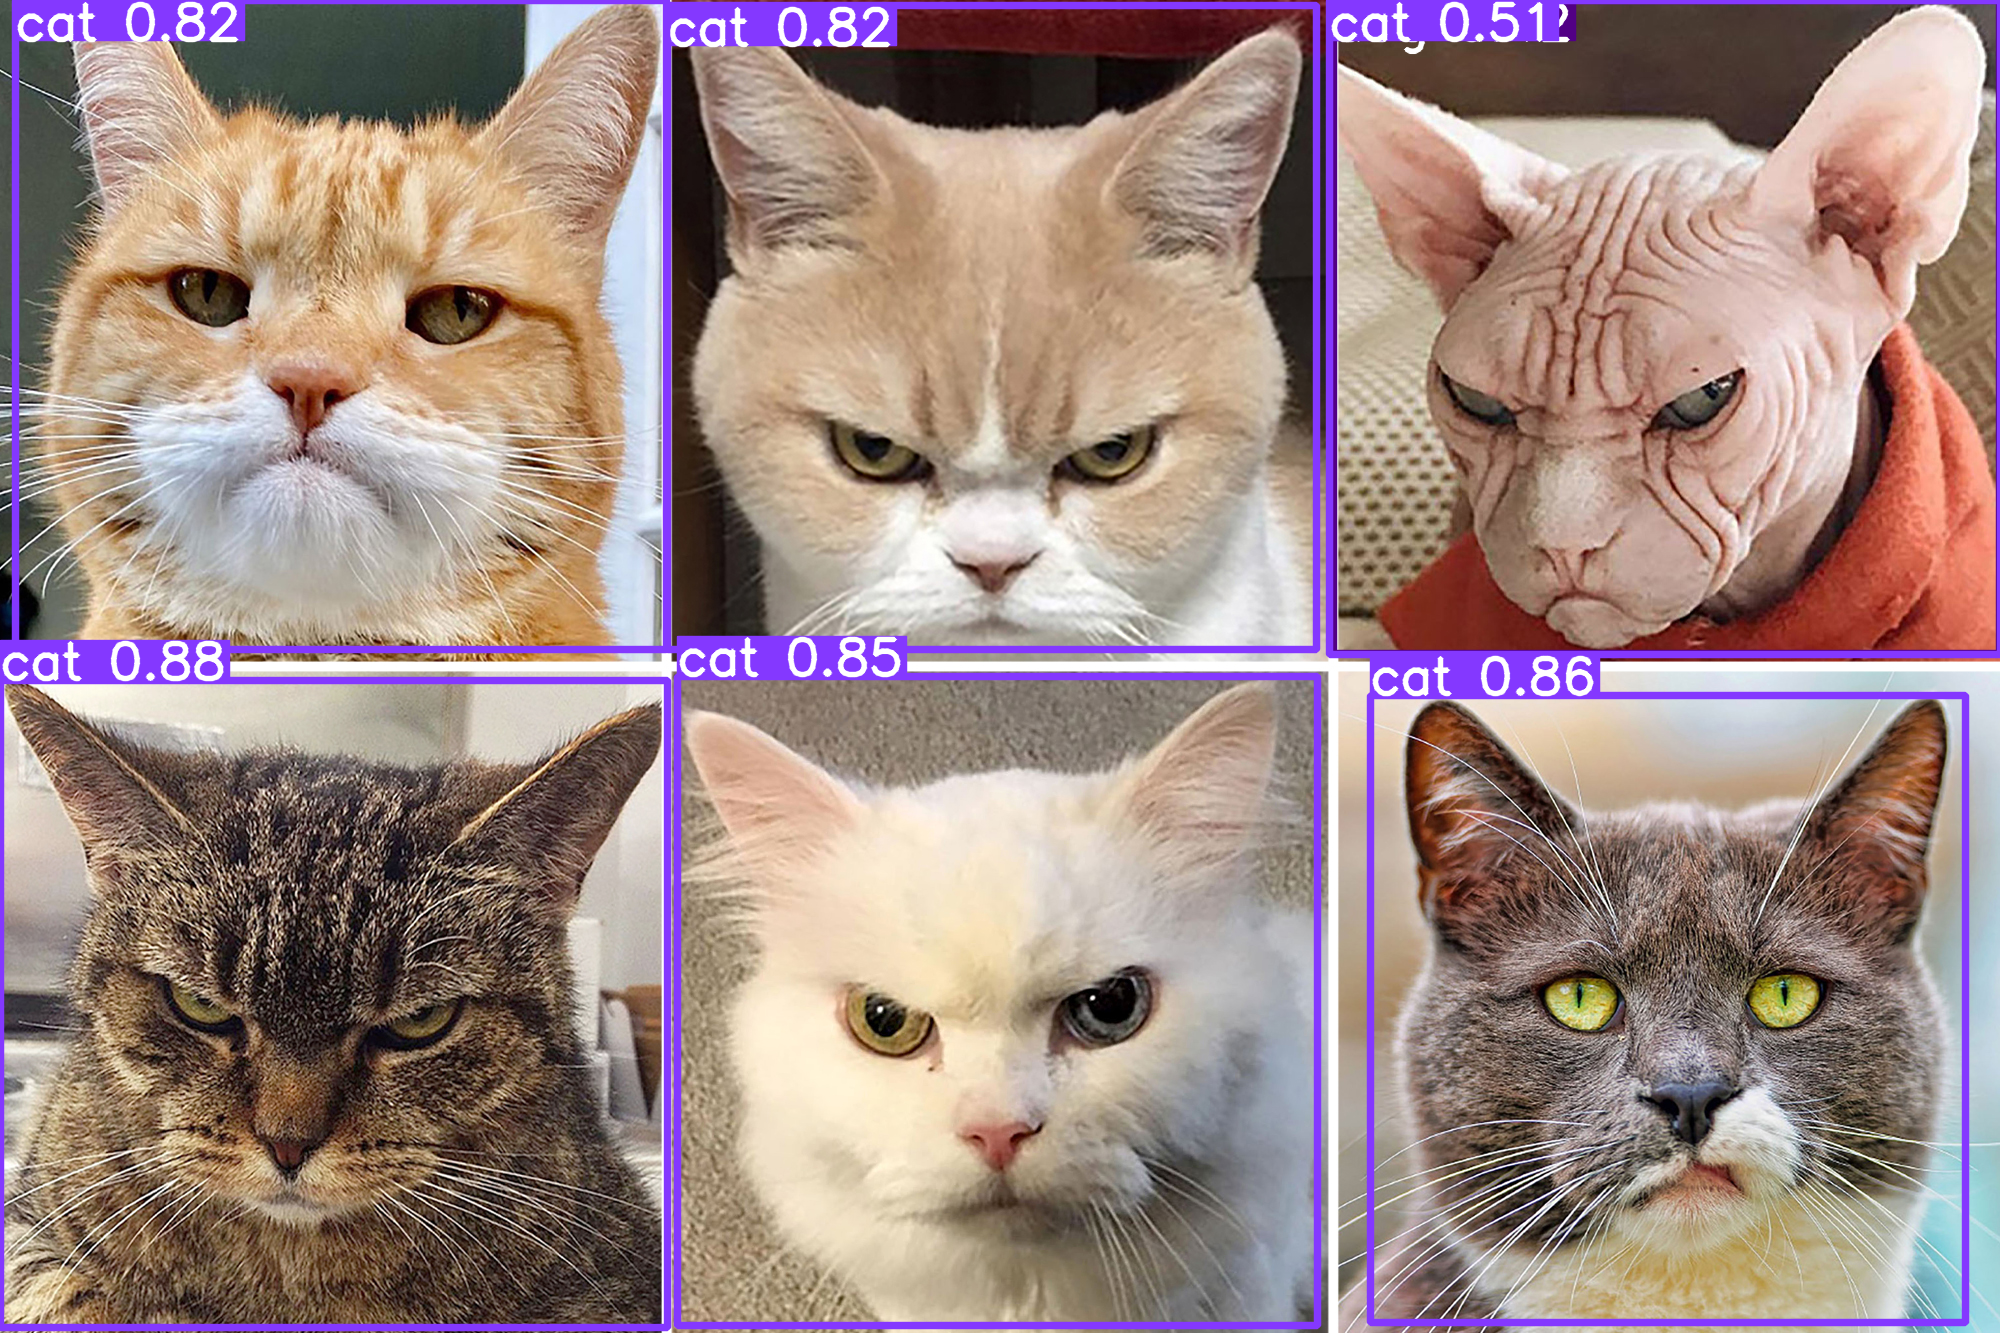

In [ ]:
results.show()

Use built in transformers to prepare images. 

In [4]:
trainset = CIFAR10(root = '.', download = True, transform=ToTensor())

100%|██████████| 170498071/170498071 [00:17<00:00, 9663420.71it/s]


Extracting ./cifar-10-python.tar.gz to .


In [5]:
# Combine Transformations (similar to Pipeline)
transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

In [7]:
trainset = CIFAR10(root = '.', download = True, transform=transform)

Files already downloaded and verified


In [8]:
# Forming batches using DataLoader
trainloader = DataLoader(trainset, batch_size = 24)

In [9]:
testset = CIFAR10('.', train = False, transform=transform)

In [10]:
# not shuffling the test batches
test_loader = DataLoader(testset, batch_size = 24, shuffle = False)

In [11]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck')

In [12]:
# get a random training image
im, label = trainloader.dataset[0]

In [13]:
im.shape # 3 stands for 3 channels - RGB in this case

torch.Size([3, 32, 32])

In [16]:
label

6

In [14]:
#size of one image - only red channel values
im[0].shape 

torch.Size([32, 32])

In [17]:
#size of batch
plt.imshow(np.transpose(im, (1, 2, 0)))
plt.title(classes[int(label)]);

### Define Convolutional Neural Network

$$\text{INPUT} = (C_{in}, H_{in}, W_{in})$$

$$\text{OUTPUT} = (C_{out}, H_{out}, W_{out})$$

$$H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}[0] - \text{dilation}[0]
                    \times (\text{kernel\_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor$$

$$W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}[1] - \text{dilation}[1]
                    \times (\text{kernel\_size}[1] - 1) - 1}{\text{stride}[1]} + 1\right\rfloor$$

In [18]:
nn.Conv2d?

In [19]:
#example conv2d
layer_1 = nn.Conv2d(
    in_channels=3, 
    out_channels =16, 
    kernel_size= 3, 
    stride =1, 
    padding= 1)

In [20]:
#data through
x = layer_1(im)

In [21]:
#shape?
x.shape

torch.Size([16, 32, 32])

In [22]:
#pool and examine
pool_1 = nn.MaxPool2d(2)
x = pool_1(x)
x.shape

torch.Size([16, 16, 16])

In [23]:
#convolve again
layer_2 = nn.Conv2d(
    in_channels = 16, 
    out_channels = 8,
    kernel_size = 3,
    stride = 1,
    padding = 1             
    )
x = layer_2(x)
x.shape

torch.Size([8, 16, 16])

In [24]:
# pool again
x = pool_1(x)
x.shape

torch.Size([8, 8, 8])

In [25]:
#flatten
f = nn.Flatten()
x = f(x)
x.shape # 8 images for each channel flattened

torch.Size([8, 64])

In [27]:
linear_1 = nn.Linear(in_features = 64, out_features = 100)
x = linear_1(x)
x.shape # each operation until the final flatening is done on a channel basis - consider every image as 3 images in case of RGB

torch.Size([8, 100])

In [28]:
import torch.nn as nn
import torch.nn.functional as F

In [36]:
class CNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(16, 10, 3, padding = 1)
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(64*10, 128)
    self.linear2 = nn.Linear(128, 32)
    self.output = nn.Linear(32, 10)

  def forward(self, x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool1(F.relu(self.conv2(x)))
    x = self.flatten(x)
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.output(x)
    return x

In [31]:
import torch.optim as optim

In [38]:
# instantiate
model = CNet()

In [39]:
#criteria and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [40]:
#train briefly 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [41]:
for epoch in range(20):
  loss = 0
  for i, data in enumerate(trainloader):
    inputs, labels = data 
    optimizer.zero_grad()
    inputs = inputs.to(device)
    labels = labels.to(device)
    output = model(inputs)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    loss += loss.item()

  print(f'Epoch: {epoch + 1}, Loss: {loss}')

Epoch: 1, Loss: 4.427687644958496
Epoch: 2, Loss: 4.842850208282471
Epoch: 3, Loss: 4.295065879821777
Epoch: 4, Loss: 3.8284378051757812
Epoch: 5, Loss: 3.6466705799102783
Epoch: 6, Loss: 3.362163782119751
Epoch: 7, Loss: 3.0896806716918945
Epoch: 8, Loss: 2.8002936840057373
Epoch: 9, Loss: 2.747204542160034
Epoch: 10, Loss: 2.7628731727600098
Epoch: 11, Loss: 2.661912441253662
Epoch: 12, Loss: 2.5758121013641357
Epoch: 13, Loss: 2.56013822555542
Epoch: 14, Loss: 2.4688878059387207
Epoch: 15, Loss: 2.3706395626068115
Epoch: 16, Loss: 2.316540479660034
Epoch: 17, Loss: 2.2448296546936035
Epoch: 18, Loss: 2.0747241973876953
Epoch: 19, Loss: 1.8878618478775024
Epoch: 20, Loss: 1.7722525596618652


In [42]:
correct = 0
total = 0
#accuracy of test data
with torch.no_grad():
  for data in test_loader:
    images, labels = data 
    images = images.to(device)
    labels = labels.to(device)
    yhat = model(images)
    _, predicted = torch.max(yhat.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

In [43]:
correct/total

0.6556

#### PROBLEM: FASHION MNIST

Adjust the convolutional network below so that the dimensions of the network abide by the format of the fashion images. Don't forget to create your batches and try to train the network for a couple of epochs. 

In [44]:
train = torchvision.datasets.FashionMNIST('.', download=True, transform = ToTensor())

100%|██████████| 26421880/26421880 [00:03<00:00, 8666822.06it/s] 


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 140623.27it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2585309.35it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6486115.05it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [58]:
testset = torchvision.datasets.FashionMNIST('.', train = False, transform=ToTensor())
test_loader = DataLoader(testset, batch_size = 24, shuffle = False)

In [45]:
train.data[0].shape

torch.Size([28, 28])

In [62]:
plt.imshow(train.data[100], cmap = 'gray')

In [49]:
train.data.shape

torch.Size([60000, 28, 28])

In [47]:
type(train.data[100])

torch.Tensor

In [50]:
trainloader = DataLoader(train, batch_size = 24)

In [52]:
class CNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 28, 3, padding =1)
    self.pool = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(28, 10, 3, padding = 1)
    self.flatten = nn.Flatten()
    self.linear_1 = nn.Linear(7*7*10, 128)
    self.linear_2 = nn.Linear(128, 32)
    self.linear_3 = nn.Linear(32, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.flatten(x)
    x = F.relu(self.linear_1(x))
    x = F.relu(self.linear_2(x))
    x = self.linear_3(x)
    return x

In [53]:
# instantiate
model = CNet()

In [54]:
#criteria and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [55]:
#train briefly 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [56]:
for epoch in range(20):
  loss = 0
  for i, data in enumerate(trainloader):
    inputs, labels = data 
    optimizer.zero_grad()
    inputs = inputs.to(device)
    labels = labels.to(device)
    output = model(inputs)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    loss += loss.item()

  print(f'Epoch: {epoch + 1}, Loss: {loss}')

Epoch: 1, Loss: 1.2836374044418335
Epoch: 2, Loss: 0.9377737045288086
Epoch: 3, Loss: 0.7528140544891357
Epoch: 4, Loss: 0.6710405945777893
Epoch: 5, Loss: 0.5640831589698792
Epoch: 6, Loss: 0.5276803970336914
Epoch: 7, Loss: 0.5086882710456848
Epoch: 8, Loss: 0.4727781116962433
Epoch: 9, Loss: 0.46474316716194153
Epoch: 10, Loss: 0.41350603103637695
Epoch: 11, Loss: 0.38807740807533264
Epoch: 12, Loss: 0.37697723507881165
Epoch: 13, Loss: 0.33464542031288147
Epoch: 14, Loss: 0.29983973503112793
Epoch: 15, Loss: 0.2835098206996918
Epoch: 16, Loss: 0.2815321385860443
Epoch: 17, Loss: 0.2825043201446533
Epoch: 18, Loss: 0.2713370621204376
Epoch: 19, Loss: 0.2605268061161041
Epoch: 20, Loss: 0.2619018852710724


In [59]:
correct = 0
total = 0
#accuracy of test data
with torch.no_grad():
  for data in test_loader:
    images, labels = data 
    images = images.to(device)
    labels = labels.to(device)
    yhat = model(images)
    _, predicted = torch.max(yhat.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

In [60]:
correct/total

0.8977

### Autoencoders with `pytorch`

- Build basic autoencoder to reconstruct fashion objects
- Use Convolutional network to build encoder/decoder architecture 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Autoencoder_schema.png/440px-Autoencoder_schema.png)

In [63]:
N, M = train.data[0].shape

In [64]:
train = torchvision.datasets.FashionMNIST('.', download=True, transform = ToTensor())
train_loader = DataLoader(train, batch_size = 64)

In [65]:
train_loader.dataset[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
encoder(train_loader.dataset[0][0].reshape(-1, N*M))

In [66]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(M*N, 100),
        nn.ReLU(),
        nn.Linear(100, 50),
        nn.ReLU(),
        nn.Linear(50, 20),
        nn.ReLU(),
        nn.Linear(20, 4)
    )

    self.decoder = nn.Sequential(
        nn.Linear(4, 20),
        nn.ReLU(),
        nn.Linear(20, 50),
        nn.ReLU(),
        nn.Linear(50, 100),
        nn.ReLU(),
        nn.Linear(100, M*N),
        nn.Sigmoid(),
    )

  def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x

In [67]:
fig, ax = plt.subplots(2, 5, figsize = (30, 10))
for i in range(5):
  ax[0, i].imshow(outputs[i][1][i].cpu().detach().numpy().reshape(28, 28))
  ax[1, i].imshow(outputs[i][0][i].cpu().detach().numpy().reshape(28, 28))

NameError: ignored

In [ ]:
class CNNAutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, 3, padding = 1), # N, 16, 28, 28
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, padding = 1), # N, 32, 28, 28
        nn.ReLU(),
        nn.Conv2d(32, 64, 7, padding = 1),
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7, padding = 1),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, padding = 1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, padding = 1),
        nn.Sigmoid()
    )

  def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x

In [ ]:
fig, ax = plt.subplots(2, 5, figsize = (30, 10))
for i in range(5):
  ax[0, i].imshow(outputs[i][0][i].cpu().detach().numpy().reshape(28, 28))
  fig.axes[0].set_ylabel('Original Image', rotation = 0, fontsize = 30, labelpad = 200)
  ax[1, i].imshow(outputs[i][1][i].cpu().detach().numpy().reshape(28, 28))
  fig.axes[5].set_ylabel('Reconstructed Image', rotation = 0, fontsize = 30, labelpad = 200)